In [1]:
from shapely import wkt
from shapely.geometry import Polygon


import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import ujson as json
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj




In [13]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"

train_images_crops = data_dir/"train_crops"
# train_mask_crops = data_dir/"mask_crops"
train_mask_crops = data_dir/"mask_crops_single_channel"
test_images_crops = data_dir / "test_crops"
test_mask_crops = data_dir / "test_mask_crops_single_channel"
test_masks_edt = data_dir / "test_masks_edt"
classifcation_crop_dir = data_dir/"classification_crops_post"

data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"
models_path = data_dir / "models"
train_images_crops = data_dir/"train_crops"
mask_dir_edt = data_dir /"mask_full_size_edt"
train_mask_crops = data_dir/"mask_crops_single_channel"
label_dir = data_dir/"train"/"labels"
mask_crops_edt = data_dir/"mask_crops_edt"
test_crops = data_dir/"test_crops"

In [14]:
labels = pd.read_csv(data_dir/"test_polygons_edt.csv")
labels.head()

,geometry,value,polygon_id,img_id
0,"POLYGON ((612 10, 612 12, 608 12, 608 16, 606 ...",255.0,b44cd049-e8f6-4af9-84d6-c1327af8b46d,test_localization_00000_prediction.png
1,"POLYGON ((736 0, 736 2, 738 2, 738 4, 742 4, 7...",255.0,0fa46888-a175-4802-ad94-93425524dc71,test_localization_00000_prediction.png
2,"POLYGON ((572 44, 572 48, 570 48, 570 50, 568 ...",255.0,9807c798-dcc7-4afc-859d-c55c5d5873ef,test_localization_00000_prediction.png
3,"POLYGON ((556 76, 556 78, 552 78, 552 82, 550 ...",255.0,ceb99454-2f1c-48a5-ae5f-d5e64020711e,test_localization_00000_prediction.png
4,"POLYGON ((734 38, 734 40, 732 40, 732 42, 728 ...",255.0,298c5b42-88d1-4b86-bbba-822939099be8,test_localization_00000_prediction.png


In [15]:
labels["crop_filename"] = labels.polygon_id.apply(lambda x: f"{x}.png")

In [25]:
damage_crops_test_folder = data_dir / "classification_crops_test"
classification_labels = pd.read_csv(data_dir/"train_pre_post.csv")
classification_labels["crop_filename"] = classification_labels.uuid.apply(lambda x: f"{x}.png")
classification_labels.head()

,uuid,img_id_pre,img_id_post,label,crop_filename
0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8.png
1,437988fc-fb7e-4b0e-8ccf-403015a737b3,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,437988fc-fb7e-4b0e-8ccf-403015a737b3.png
2,63d78637-7c40-40c7-a1b3-55152a64415a,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,63d78637-7c40-40c7-a1b3-55152a64415a.png
3,31ccdff0-b7f7-4884-8e55-d35e4d2c1770,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,31ccdff0-b7f7-4884-8e55-d35e4d2c1770.png
4,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b.png


In [26]:
size=64
bs=32
src = (ImageList
       .from_df(classification_labels, path=classifcation_crop_dir, cols=['crop_filename'])
       .filter_by_func(lambda f:Path(f).name )
       .split_by_rand_pct(0.2)
       .label_from_df(cols='label'))

data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .add_test_folder(damage_crops_test_folder)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

#test_data = ImageList.from_df(labels, path=damage_crops_test_folder, cols=['crop_filename'])
# data.add_test_folder(damage_crops_test_folder)

def f1(y_pred:Tensor, y_true:Tensor):
    eps=1e-10
    def to_onehot(indices, num_classes):
        """Convert a tensor of indices of any shape `(N, ...)` to a
        tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
        input's device`.
        """
        onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
                             dtype=torch.uint8,
                             device=indices.device)
        return onehot.scatter_(1, indices.unsqueeze(1), 1)
    def recall(y_pred,y_true):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        possible_positives = torch.sum(y_true)
        recall = true_positives / (possible_positives + eps)
        return recall

    def precision(y_pred,y_true):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +eps)
        return precision

    y_true = to_onehot(y_true.view(-1), num_classes=4)
    precision = precision(y_pred,y_true)
    recall = recall(y_pred,y_true)
    return 2*((precision*recall)/(precision+recall+eps))

data

ImageDataBunch;

Train: LabelList (131073 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: /media/wwymak/Storage/xView2/classification_crops_post;

Valid: LabelList (32768 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,3,0,3
Path: /media/wwymak/Storage/xView2/classification_crops_post;

Test: LabelList (33614 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: EmptyLabelList
,,,,
Path: /media/wwymak/Storage/xView2/classification_crops_post

In [27]:
models_path = data_dir / "models"
learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1] , model_dir=models_path)
learn.to_fp16();
learn.load('15Nov-classification_full_dataset');

In [28]:
predictions = learn.get_preds(DatasetType.Test);

In [50]:
predictions[0]

tensor([[0.5370, 0.1131, 0.3440, 0.0059],
        [0.8794, 0.0708, 0.0411, 0.0087],
        [0.9599, 0.0114, 0.0260, 0.0027],
        ...,
        [0.9340, 0.0183, 0.0430, 0.0048],
        [0.7526, 0.1379, 0.0978, 0.0116],
        [0.9691, 0.0126, 0.0163, 0.0020]])

In [35]:
labels.shape

(33970, 5)

In [29]:
polygon_ids = [x.name.replace('.png', '') for x in data.test_dl.dataset.items]
prediction_cls = [x+1 for x in predictions[1].numpy()]

test_results = pd.DataFrame(data={'polygon_id': polygon_ids, 'damage_cls': prediction_cls})
test_results = labels.merge(test_results, left_on='polygon_id', right_on='polygon_id')
test_results.shape

(33614, 6)

In [30]:
test_results.geometry = test_results.geometry.apply(lambda x: wkt.loads(x).exterior)

In [31]:
test_results.head()

,geometry,value,polygon_id,img_id,crop_filename,damage_cls
0,"LINEARRING (612 10, 612 12, 608 12, 608 16, 60...",255.0,b44cd049-e8f6-4af9-84d6-c1327af8b46d,test_localization_00000_prediction.png,b44cd049-e8f6-4af9-84d6-c1327af8b46d.png,1
1,"LINEARRING (736 0, 736 2, 738 2, 738 4, 742 4,...",255.0,0fa46888-a175-4802-ad94-93425524dc71,test_localization_00000_prediction.png,0fa46888-a175-4802-ad94-93425524dc71.png,1
2,"LINEARRING (572 44, 572 48, 570 48, 570 50, 56...",255.0,9807c798-dcc7-4afc-859d-c55c5d5873ef,test_localization_00000_prediction.png,9807c798-dcc7-4afc-859d-c55c5d5873ef.png,1
3,"LINEARRING (556 76, 556 78, 552 78, 552 82, 55...",255.0,ceb99454-2f1c-48a5-ae5f-d5e64020711e,test_localization_00000_prediction.png,ceb99454-2f1c-48a5-ae5f-d5e64020711e.png,1
4,"LINEARRING (734 38, 734 40, 732 40, 732 42, 72...",255.0,298c5b42-88d1-4b86-bbba-822939099be8,test_localization_00000_prediction.png,298c5b42-88d1-4b86-bbba-822939099be8.png,1


In [32]:
test_results.damage_cls.unique()

array([1])

In [51]:
predictions2 = learn.get_preds(DatasetType.Valid)
predictions2[1].unique()

tensor([0, 1, 2, 3])

In [52]:
pd.Series(predictions2[1].numpy()).value_counts(normalize=True)

0    0.741438
1    0.089351
2    0.086494
3    0.082716
dtype: float64

In [33]:
predictions, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
y = torch.argmax(predictions, dim=1)

In [34]:
polygon_ids = [x.name.replace('.png', '') for x in data.test_dl.dataset.items]
prediction_cls = [x+1 for x in y.numpy()]

test_results = pd.DataFrame(data={'polygon_id': polygon_ids, 'damage_cls': prediction_cls})
test_results = labels.merge(test_results, left_on='polygon_id', right_on='polygon_id')
test_results.geometry = test_results.geometry.apply(lambda x: wkt.loads(x).exterior)
test_results.img_id = test_results.img_id.str.replace('pre', 'post')
test_results.shape, test_results.damage_cls.unique()

((33614, 6), array([1, 4, 2, 3]))

In [35]:
test_results.damage_cls.value_counts(normalize=True)

1    0.919557
4    0.061373
3    0.010145
2    0.008925
Name: damage_cls, dtype: float64

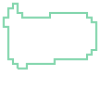

In [36]:
test_results.geometry[100]

In [37]:
from cv2 import fillPoly, imwrite
def create_image(img_id, output_path):
    
    mask_img = np.zeros((1024,1024,1), np.uint8)
    img_polys = test_results[test_results.img_id == img_id]
    if len(img_polys) > 0:
        for r in img_polys.iterrows():
            row = r[1]
            poly_np = np.array(row.geometry.coords, np.int32)
            fillPoly(mask_img, [poly_np], row['damage_cls'])

    imwrite(str(output_path/img_id), mask_img)
    return mask_img

In [67]:
(data_dir/"test_masks").ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/test_masks/test_pre_00909.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_masks/test_pre_00371.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_masks/test_pre_00824.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_masks/test_pre_00270.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_masks/test_pre_00186.png')]

In [39]:
output_path = data_dir/"test_masks_edt"
img_ids = [x.name for x in (data_dir/"test"/"images").ls() if 'post' in x.name]
len(img_ids)
img_ids[:5]

['test_post_00082.png',
 'test_post_00294.png',
 'test_post_00839.png',
 'test_post_00627.png',
 'test_post_00128.png']

In [40]:
outputs = [create_image(img_id, output_path) for img_id in tqdm(img_ids)]

100%|██████████| 933/933 [00:03<00:00, 297.68it/s]


In [85]:
np.array(outputs).max()

4

In [92]:
def rename_to_submit(img_path):
    img_path.rename(Path(img_path.parent, img_path.name.replace('post', 'damage').replace('pre', 'localization').replace('.png', '_prediction.png')))

In [93]:
_=[rename_to_submit(x) for x in output_path.ls()]

In [94]:
output_path.ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/test_masks/test_damage_00732_prediction.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_masks/test_localization_00923_prediction.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_masks/test_localization_00265_prediction.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_masks/test_localization_00058_prediction.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_masks/test_damage_00099_prediction.png')]